### reinforce_ff_multiseq_play_varlen_2
* took from **reinforce_ff_multiseq_play_3**
* RL - Gradient - FeedForward agent
* finishes the episode if reward drops to a value, that is the maximum reward of previous episode, only if it is better than current.
* next episode starts with a random sequence
* next reward for the gradient calculatin is the best reward found so far

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
import time

In [2]:
max_no_of_layers = 15
len_search_space = 382 +1
end_token = 382

alpha = 1e-3   # learning rate in the policy gradient
gamma = 0.99  # decay rate of past observations
learning_rate = 1e-4  # learning rate of NN agent

reward_min = 0.55

no_of_episodes = 200  # number of training iterations 
max_plays = 20
min_plays = 5
rollout_n = 1  # number of episodes between policy update

states, gradients, probs, rewards = [], [], [], []

In [3]:
# model_output_shape = (max_no_of_layers-1, len_search_space)
# model = Sequential()
# model.add(Dense(128, input_shape=(max_no_of_layers-1,), activation="relu")) 
# model.add(Dense(64, activation="relu"))  
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(16, activation="relu")) 
# model.add(Dense(16, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(32, activation="relu")) 
# model.add(Dense(64, activation="relu")) 
# model.add(Dense(128, activation="relu")) 
# model.add(Dense(model_output_shape[0]*model_output_shape[1], activation="softmax")) 
# model.add(Reshape(model_output_shape))
# model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [4]:
model_output_shape = (max_no_of_layers-1, len_search_space)
model = Sequential()
model.add(Dense(512, input_shape=(max_no_of_layers-1,), activation="relu")) 
model.add(Dense(256, activation="relu"))  
model.add(Dense(128, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(16, activation="relu")) 
model.add(Dense(16, activation="relu")) 
model.add(Dense(32, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dense(128, activation="relu")) 
model.add(Dense(256, activation="relu")) 
model.add(Dense(512, activation="relu")) 
model.add(Dense(model_output_shape[0]*model_output_shape[1], activation="softmax")) 
model.add(Reshape(model_output_shape))
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2

In [6]:
def plot_distribution(samples, prob, next_):
    fig, axs = plt.subplots(len(next_), figsize=(24, 6))
    for i in range(len(next_)):
        axs[i].axvline(x=next_[i], c="r", alpha=0.5)
        axs[i].plot(range(0, samples), prob[i])
        axs[i].axis('off')    
    plt.show()

In [7]:
acc_model = keras.models.load_model("accuracy_predictor_15.h5")  # input shape: (15, 383)
def performance_estimate(sequence):
    if end_token in sequence:
        sequence = np.append(sequence, 0)
    else:
        sequence = np.append(sequence, end_token)  # adding end token
        
    seq_hot = keras.utils.to_categorical(sequence, num_classes=len_search_space)[np.newaxis]
    acc = acc_model.predict(seq_hot)[0][0]
    return round(acc, 3)

In [8]:
def get_action(state):
    actions = []
    distributions = model.predict(state)
    for distribution in distributions[0]:
        distribution /= np.sum(distribution)  
        action = np.random.choice(len_search_space, 1, p=distribution)[0]
        actions.append(int(action))
        if action == end_token:
            break
        
    if len(actions) < max_no_of_layers-1:
        for _ in range((max_no_of_layers-1)-len(actions)):
            actions.append(0)
            

#     plot_distribution(len_search_space, distributions[0], actions)
    return actions, distributions

In [9]:
def apply_step(init_state, play_count):
    actions, distribution = get_action(init_state)
    reward = performance_estimate(actions)
    
    done = False
    if reward < reward_min and play_count >= min_plays:
        done = True
    if play_count >= max_plays:
        done = True

    return actions, distribution, reward, done

In [10]:
def remember(state, actions, prob, reward):
    encoded_action = np.zeros(model_output_shape, np.float32) 
    for i, action in enumerate(actions):
        encoded_action[i][action] = 1    

    gradients.append(encoded_action - prob)
    states.append(state)
    rewards.append(reward)
    probs.append(prob)
        
def clear_memory():
    states.clear()
    gradients.clear()
    rewards.clear()
    probs.clear()    

In [11]:
def get_discounted_rewards(rewards_in):
    discounted_rewards = []
    cumulative_total_return = 0

    for reward in rewards_in[::-1]:  # iterate the rewards backwards and and calc the total return 
        cumulative_total_return = (cumulative_total_return * gamma) + reward
        discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards = np.mean(discounted_rewards)
    std_rewards = np.std(discounted_rewards)
    norm_discounted_rewards = (discounted_rewards - mean_rewards) / (std_rewards + 1e-7) # avoiding zero div

    return norm_discounted_rewards

In [12]:
def update_policy():
    states_ = np.vstack(states)
    
    gradients_ = np.vstack(gradients)
    rewards_ = np.vstack(rewards)
    discounted_rewards = get_discounted_rewards(rewards_)
    discounted_rewards = discounted_rewards.reshape(discounted_rewards.shape[0], discounted_rewards.shape[1], discounted_rewards.shape[1])
    gradients_ *= discounted_rewards
    probs_ = probs
#     probs_ = np.clip(probs_, 1e-36, 1e36)
    gradients_ = alpha * gradients_ + np.vstack(probs)
    
    history = model.train_on_batch(states_, gradients_)
    clear_memory()
    return history

In [13]:
history_accuracy_per_play = []
history_sequence_per_play = []
history_loss = []
history_sequence_per_episode = []
history_accuracy_per_episode = []
history_avg_accuracy_per_episode = []
history_play_counts = []
history_rewards = []
history_minmax = []
history_bestsofar = []

rew = 0.7

t1 = time.time()
sequence = np.random.randint(1, len_search_space, max_no_of_layers-1, dtype="int32")[np.newaxis]
# sequence = np.zeros(max_no_of_layers-1, dtype="int32")[np.newaxis]
for episode in range(no_of_episodes):
#     sequence = np.zeros(max_no_of_layers-1, dtype="int32")[np.newaxis]
#     sequence = np.random.randint(1, len_search_space, max_no_of_layers-1, dtype="int32")[np.newaxis]  # starts the episode with random sequence
    done = False          
    episode_reward = 0  
    play_counter = 0
    episode_acc = []
    episode_seq = []
    while not done:
        play_counter += 1
        actions, prob, reward, done = apply_step(sequence, play_counter)
        history_accuracy_per_play.append(reward)
        remember(sequence, actions, prob, reward)
#         remember(sequence, actions, prob, rew)
        sequence = np.array(actions)[np.newaxis]
        history_sequence_per_play.append(sequence)
        episode_reward += reward
        
        episode_acc.append(reward)
        episode_seq.append(sequence)
        
        rew = max(history_accuracy_per_play) + 0.01
        
        if len(episode_acc) >= min_plays and np.var(episode_acc) < 1e-2:
            done = True

        if done:
#             rew = max(episode_acc) + 0.005
#             rew = max(history_accuracy_per_play) + 0.01
            reward_avg = np.average(episode_acc)
#             reward_min = reward_avg if reward_avg > reward_min else reward_min  # increases the min_reward to best episode avg 
            history_minmax.append([reward_min, max(episode_acc)])
#             sequence = episode_seq[episode_acc.index(max(episode_acc))]
            sequence = history_sequence_per_play[history_accuracy_per_play.index(max(history_accuracy_per_play))]
            
            history_sequence_per_episode.append(sequence)
            history_accuracy_per_episode.append(reward)
            history_play_counts.append(play_counter)
            history_bestsofar.append(max(history_accuracy_per_play))
            history_avg_accuracy_per_episode.append(np.average(episode_acc))
            if episode%rollout_n == 0:  
                history = update_policy()
                history_loss.append(history)

    history_rewards.append(episode_reward)
    print("Episode", episode+1, "\t Plays:", play_counter, 
          "\t Max accuracy:", round(max(episode_acc), 3), "\t reward_min:", round(reward_min, 3), "\t Best accuracy:", max(history_accuracy_per_play),
          "\t loss:", history,
         )

print("DONE", int(time.time()-t1), "sec")

Episode 1 	 Plays: 5 	 Max accuracy: 0.54 	 reward_min: 0.55 	 Best accuracy: 0.54 	 loss: 5.920013904571533
Episode 2 	 Plays: 5 	 Max accuracy: 0.498 	 reward_min: 0.55 	 Best accuracy: 0.54 	 loss: 5.912330150604248
Episode 3 	 Plays: 5 	 Max accuracy: 0.512 	 reward_min: 0.55 	 Best accuracy: 0.54 	 loss: 5.928002834320068
Episode 4 	 Plays: 5 	 Max accuracy: 0.673 	 reward_min: 0.55 	 Best accuracy: 0.673 	 loss: 5.925134658813477
Episode 5 	 Plays: 5 	 Max accuracy: 0.559 	 reward_min: 0.55 	 Best accuracy: 0.673 	 loss: 4.984659194946289
Episode 6 	 Plays: 5 	 Max accuracy: 0.503 	 reward_min: 0.55 	 Best accuracy: 0.673 	 loss: 5.9345011711120605
Episode 7 	 Plays: 6 	 Max accuracy: 0.794 	 reward_min: 0.55 	 Best accuracy: 0.794 	 loss: 5.081899166107178
Episode 8 	 Plays: 5 	 Max accuracy: 0.501 	 reward_min: 0.55 	 Best accuracy: 0.794 	 loss: 5.934207916259766
Episode 9 	 Plays: 6 	 Max accuracy: 0.801 	 reward_min: 0.55 	 Best accuracy: 0.801 	 loss: 5.937857151031494
Epis

Episode 75 	 Plays: 5 	 Max accuracy: 0.794 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 4.890728950500488
Episode 76 	 Plays: 5 	 Max accuracy: 0.717 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.9242167472839355
Episode 77 	 Plays: 5 	 Max accuracy: 0.503 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.926531791687012
Episode 78 	 Plays: 5 	 Max accuracy: 0.498 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.9125165939331055
Episode 79 	 Plays: 5 	 Max accuracy: 0.763 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.9009480476379395
Episode 80 	 Plays: 5 	 Max accuracy: 0.504 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.21328067779541
Episode 81 	 Plays: 5 	 Max accuracy: 0.799 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.905643463134766
Episode 82 	 Plays: 5 	 Max accuracy: 0.499 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.896758556365967
Episode 83 	 Plays: 5 	 Max accuracy: 0.5 	 reward_min: 0.55 	 Best accuracy: 0.828 	 loss: 5.91738224

Episode 148 	 Plays: 5 	 Max accuracy: 0.497 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.881751537322998
Episode 149 	 Plays: 5 	 Max accuracy: 0.505 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.651780128479004
Episode 150 	 Plays: 5 	 Max accuracy: 0.679 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.644290447235107
Episode 151 	 Plays: 5 	 Max accuracy: 0.499 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.863070011138916
Episode 152 	 Plays: 5 	 Max accuracy: 0.729 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.883133411407471
Episode 153 	 Plays: 5 	 Max accuracy: 0.505 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.858190059661865
Episode 154 	 Plays: 5 	 Max accuracy: 0.68 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.175473213195801
Episode 155 	 Plays: 5 	 Max accuracy: 0.754 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.140214443206787
Episode 156 	 Plays: 5 	 Max accuracy: 0.743 	 reward_min: 0.55 	 Best accuracy: 0.863 	 loss: 5.

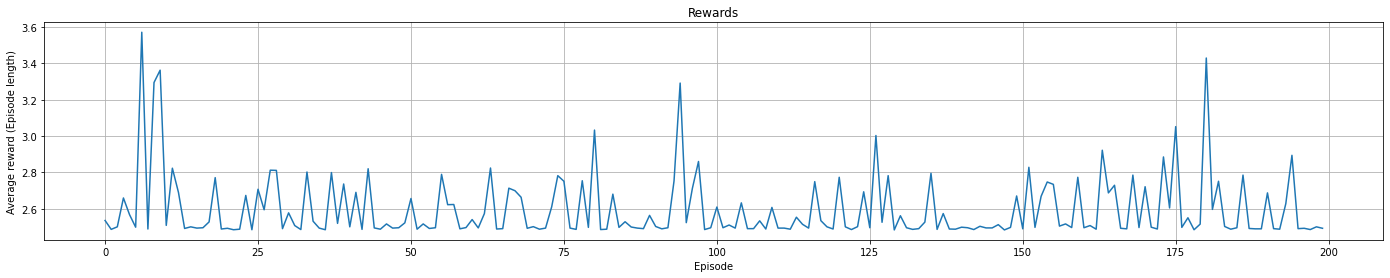

In [14]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_rewards)), history_rewards)
plt.title("Rewards")
plt.xlabel("Episode")
plt.ylabel("Average reward (Episode length)")
plt.grid()
plt.show()

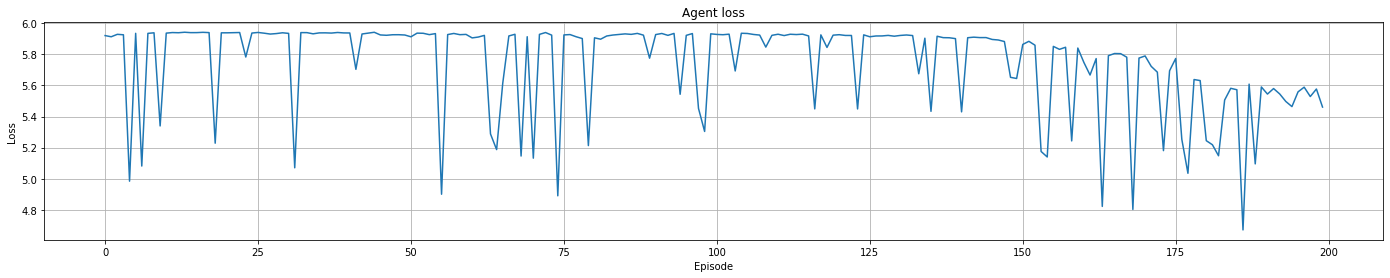

In [15]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_loss)), history_loss)
plt.title("Agent loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
# plt.axhline(y=0, c="k")
plt.grid()
plt.show()

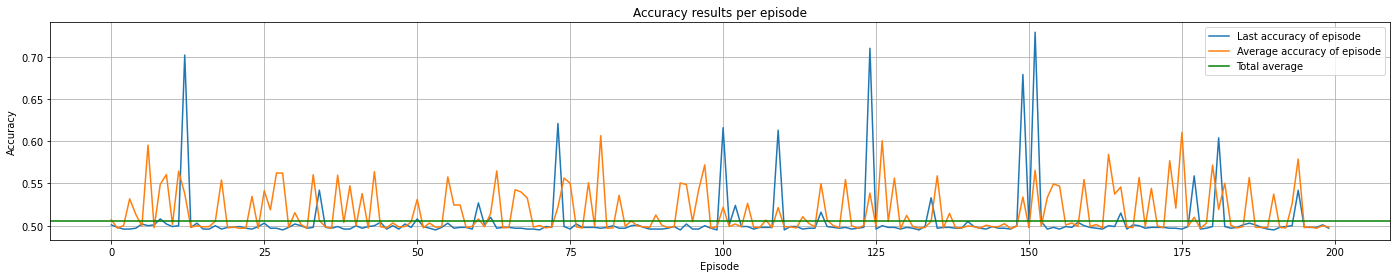

Best accuracy: 0.729
Average accuracy: 0.506115
Last accuracy: 0.497


In [16]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_accuracy_per_episode)), history_accuracy_per_episode, label="Last accuracy of episode")
plt.plot(np.arange(0,len(history_avg_accuracy_per_episode)), history_avg_accuracy_per_episode, label="Average accuracy of episode")
plt.axhline(y=np.average(history_accuracy_per_episode), c="g", label="Total average")
plt.title("Accuracy results per episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()
print("Best accuracy:", max(history_accuracy_per_episode))
print("Average accuracy:", np.average(history_accuracy_per_episode))
print("Last accuracy:", history_accuracy_per_episode[-1])

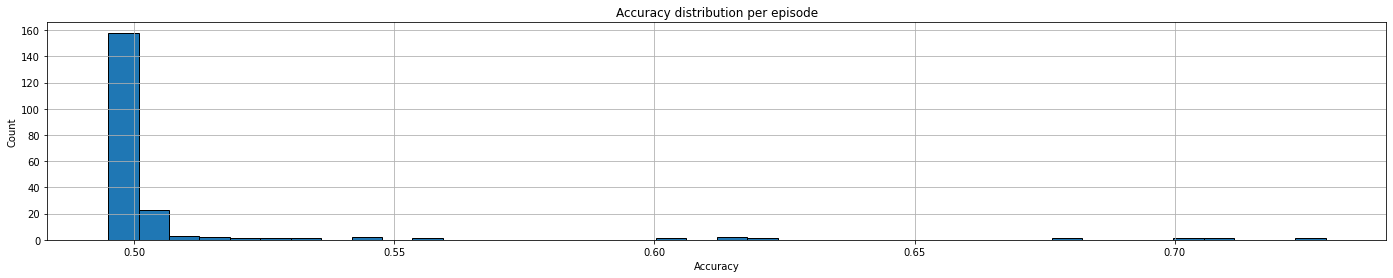

In [17]:
fig = plt.figure(figsize=(24, 4))
bins = int(len(history_accuracy_per_episode)/5)
plt.hist(history_accuracy_per_episode, bins=bins, edgecolor="k")
plt.title("Accuracy distribution per episode")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.grid()
plt.show()

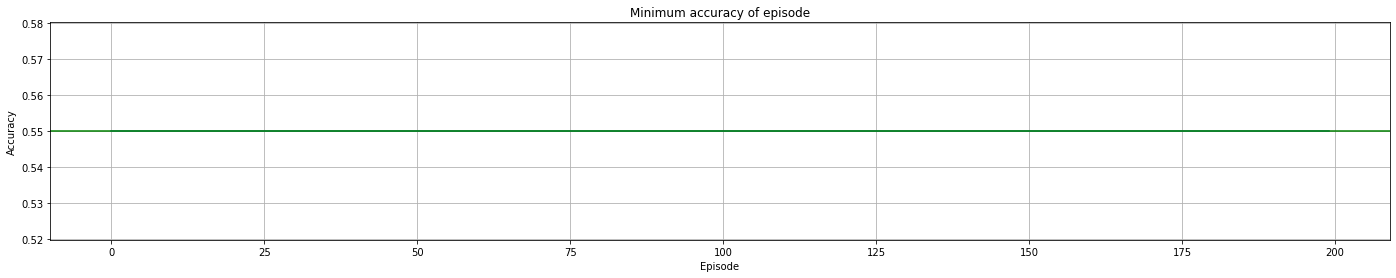

In [18]:
min_acc =  [i[0] for i in history_minmax]
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(min_acc)), min_acc)
plt.axhline(y=np.average(min_acc), c="g")
plt.title("Minimum accuracy of episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

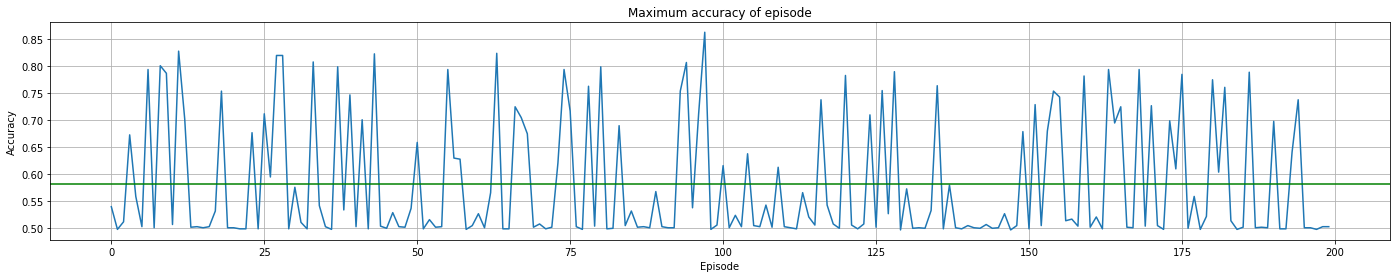

In [19]:
max_acc =  [i[1] for i in history_minmax]
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(max_acc)), max_acc)
plt.axhline(y=np.average(max_acc), c="g")
plt.title("Maximum accuracy of episode")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

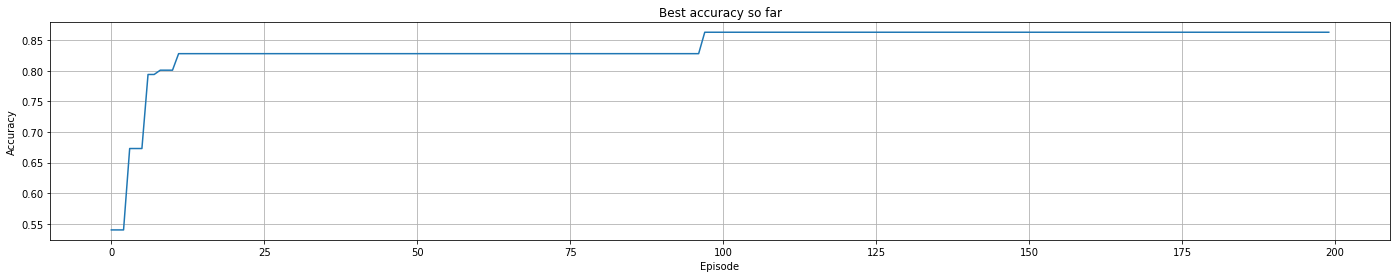

In [20]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_bestsofar)), history_bestsofar)
plt.title("Best accuracy so far")
plt.xlabel("Episode")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

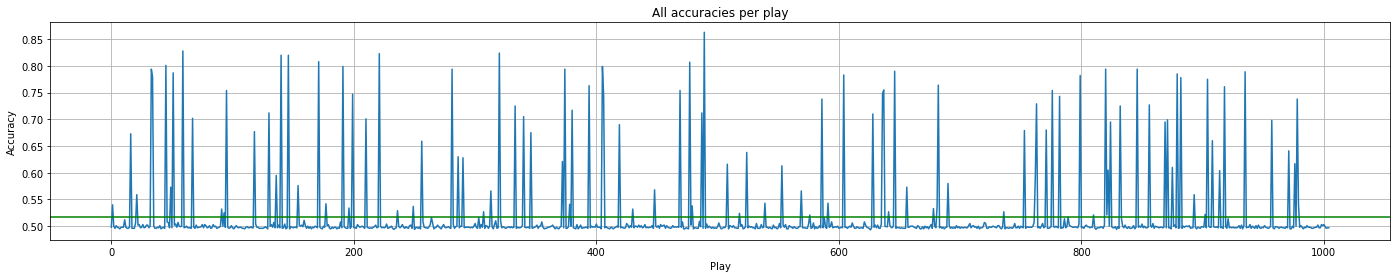

Best accuracy: 0.863
Average accuracy: 0.51669353


In [21]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_accuracy_per_play)), history_accuracy_per_play)
plt.axhline(y=np.average(history_accuracy_per_play), c="g")
plt.title("All accuracies per play")
plt.xlabel("Play")
plt.ylabel("Accuracy")
plt.grid()
plt.show()
print("Best accuracy:", max(history_accuracy_per_play))
print("Average accuracy:", np.average(history_accuracy_per_play))

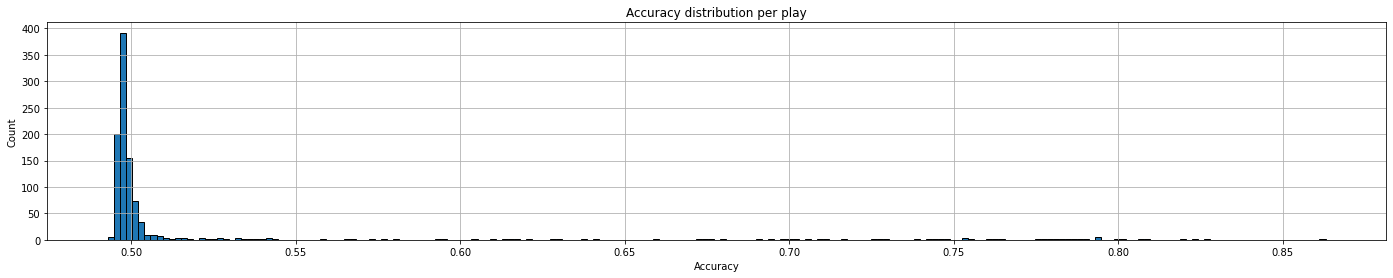

In [22]:
fig = plt.figure(figsize=(24, 4))
bins = int(len(history_accuracy_per_play)/5)
plt.hist(history_accuracy_per_play, bins=bins, edgecolor="k")
plt.title("Accuracy distribution per play")
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.grid()
plt.show()

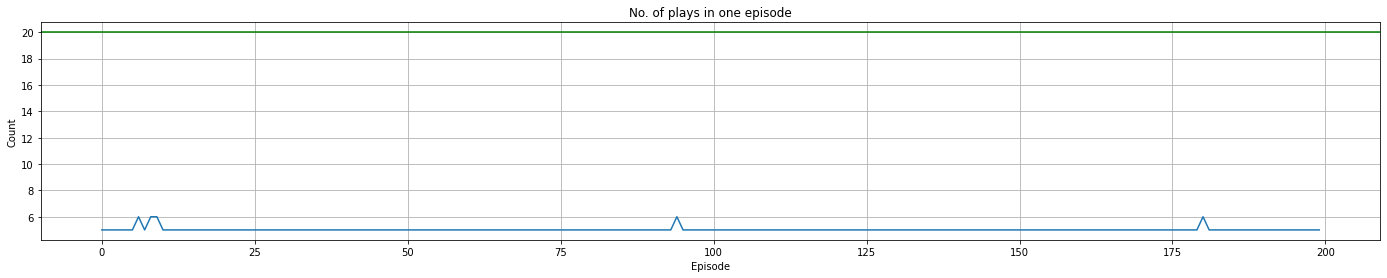

In [23]:
fig = plt.figure(figsize=(24, 4))
plt.plot(np.arange(0,len(history_play_counts)), history_play_counts)
plt.axhline(y=max_plays, c="g")
plt.title("No. of plays in one episode")
plt.xlabel("Episode")
plt.ylabel("Count")
plt.grid()
plt.show()

In [24]:
# for s, a in zip(history_sequence_per_episode, history_accuracy_per_episode):
#     length = np.where(s == end_token)[1][0]+1
#     print(s, "\t Length:", length, "\t Accuracy:", round(a, 3))

for s, a in zip(history_sequence_per_play, history_accuracy_per_play):
    print(s, "\t Accuracy:", round(a, 3))

[[124 182  17 319 129  23 278  64   0  60  64  84  81 229]] 	 Accuracy: 0.498
[[149 364  86 148 349 302  39 354  54 361 160  21 353  20]] 	 Accuracy: 0.54
[[214 348  34  18 157 243  63 379  19 198  18 333 164 357]] 	 Accuracy: 0.5
[[ 98 235 368 135 368 155 213 321 238  84 358 288  13 146]] 	 Accuracy: 0.496
[[ 33 222 150  26 256 320 119 112 313 254 306 306 149 267]] 	 Accuracy: 0.501
[[ 75  98  29 135 270  39 327 374 180 370 193 151 166 196]] 	 Accuracy: 0.498
[[330 246 292 216 373 289 346 318 277 277 120  80 344 145]] 	 Accuracy: 0.497
[[220 133 364 154 305 354  92 270  81 227 247 308 364 320]] 	 Accuracy: 0.495
[[361 126  43 314 226 189 345 129 298  60 137 163 367 253]] 	 Accuracy: 0.498
[[119 317 370 370 148  43 339  18 227 375  81  95 246 184]] 	 Accuracy: 0.498
[[248 269 241  96 100 212 175  36 124  85 281 255  70  95]] 	 Accuracy: 0.498
[[240 284 268  70 161 159 370  80   1 279  94  73  71  61]] 	 Accuracy: 0.512
[[354 144 317 250 324 304 310   8 233  21  68   2 277 273]] 	 Accur

[[355 191 255   8  96   7   6 112  99 226 263 237  29 168]] 	 Accuracy: 0.496
[[106 211  55 377  99 163  16  92 237 372 101   4 345 128]] 	 Accuracy: 0.503
[[329 284  16  24 108  28  25 265 310 225 330  47 210 104]] 	 Accuracy: 0.498
[[ 39 197 269 371  76 193  53 165 212 315 303  65 265 199]] 	 Accuracy: 0.527
[[268 259 178 120 288 158 375 281 188 268 254 339 143 105]] 	 Accuracy: 0.496
[[351  64 169 188 300  79 168  53 127 252 310 205 344  58]] 	 Accuracy: 0.501
[[223 179 167 139 319 270  17 249 212  48 244  63 324 208]] 	 Accuracy: 0.5
[[175 356   3 177   9  24 270 335 317 317  89  39 362  49]] 	 Accuracy: 0.496
[[ 87  80  95  55 210 381 194 185   8 123 327 138 245 265]] 	 Accuracy: 0.501
[[ 63  56 220  38 310 321 308 120  72 100  71 360 296 267]] 	 Accuracy: 0.566
[[206 200 297 176 251 294  19 192 195 288 337 232 208  22]] 	 Accuracy: 0.499
[[132 279 156 129  52 172 149 278 254 346  88  93 241 196]] 	 Accuracy: 0.495
[[308   1 318 273 296  28 358 219 206 361  23  57 206 347]] 	 Accu

[[ 18 259  67 281 296 284 203 144 301 126 372 278  19   0]] 	 Accuracy: 0.497
[[217 338  93 357 216 342 227 382   0   0   0   0   0   0]] 	 Accuracy: 0.738
[[290  30 347 284  85  19 275 280 154 150 165 307 343  42]] 	 Accuracy: 0.497
[[212 128  34 228  55 294 103 199  63  46 264 188 253  65]] 	 Accuracy: 0.516
[[ 55  44 347  83 275  76 303 133 325   7 105 353  63 173]] 	 Accuracy: 0.498
[[193 110  20 347  37 215  38 299 254 260  28 171 270  78]] 	 Accuracy: 0.496
[[257 176 262 172 338 203  15 102  85 303 180 150 128 263]] 	 Accuracy: 0.543
[[257 334 332 252 196 131 290 185 174 175  25 270 379 281]] 	 Accuracy: 0.498
[[251 106  75 214 124 326 219  40 104 336  22 117 225 316]] 	 Accuracy: 0.499
[[ 10 244 168 350 164 186 153 330 340  89 333 218  72 168]] 	 Accuracy: 0.508
[[191 313 219  86 158 304 248  80 153  84 211  58 382   0]] 	 Accuracy: 0.497
[[128 160  71  60  77 343 349 281 275 304 301 206 116  69]] 	 Accuracy: 0.498
[[362 218 281  16 195   7 311 218 177  84  84 269 312  20]] 	 Ac

[[380 364 167 367 333 345 187 362 280 320 103 342  55 168]] 	 Accuracy: 0.499
[[224 334 167 295 303 170 362 156 373 340 272 256 224 119]] 	 Accuracy: 0.499
[[240 149 280 370 138  25 194 183 310  31 264 276  52 366]] 	 Accuracy: 0.497
[[ 27 364 103 373   9 154 198 172  18 227 350 340 226  55]] 	 Accuracy: 0.498
[[214  38 286 203  59 175 220 302  41 112 301 192 255 382]] 	 Accuracy: 0.498
[[ 18 137 352 278   2 126 248 237 363 336   5 382   0   0]] 	 Accuracy: 0.521
[[155 262  69  82 102 268 155  80 211  60 124 334 199 265]] 	 Accuracy: 0.497
[[349 182 136 124 358  15 101 122 149  12 349 182 380  55]] 	 Accuracy: 0.494
[[327  61 314  74 334 339 210   0  41 247 306 295 294 274]] 	 Accuracy: 0.497
[[316   7 165 150 314 360 341 330  81  38 340  25  55  72]] 	 Accuracy: 0.497
[[366 277 351 166 336  89 174 377 214 105   2 216  79 204]] 	 Accuracy: 0.497
[[217 299  19  26 174 117 162 237 174 363 274 207  23 362]] 	 Accuracy: 0.499
[[ 13  89 246 275 208 268 325 346 116   2 192  59  98  13]] 	 Ac

In [25]:
best_sequence = history_sequence_per_play[history_accuracy_per_play.index(max(history_accuracy_per_play))]
print("Best sequence:", best_sequence, "\t with accuracy:", performance_estimate(best_sequence[0]), "\t Explored:", len(history_sequence_per_play))

Best sequence: [[  2 204 177 371  61 281 339 382   0   0   0   0   0   0]] 	 with accuracy: 0.863 	 Explored: 1005


* Best sequence: [[  2 204 177 371  61 281 339 382   0   0   0   0   0   0]] 	 with accuracy: 0.863 	 Explored: 1005

var len
* start with best found so far
* alpha = 1e-3
* 200 episodes
* Best sequence: [[124 147 140 169  49  26 348  28 163 194   2 349 373   9]] 	 with accuracy: 0.858 	 Explored: 1009
* 500 episodes
* Best sequence: [[131 138 343  68 155 168 163  11  77 166  56 107  51 368]] 	 with accuracy: 0.941 	 Explored: 2531
* Best sequence: [[126 240 267 150 222 119 126 257 296 126   6 155  15 225]] 	 with accuracy: 0.846 	 Explored: 2510
* Best sequence: [[264 365  88 264 137  14  73 377 186  91 248 313 333  75]] 	 with accuracy: 0.882 	 Explored: 2518
* 1000 episodes
* Best sequence: [[257 376 269 104  65  46 296 159 128 163 211  91 295  74]] 	 with accuracy: 0.887 	 Explored: 5021

Fixed len 15
* start with zeros
* alpha = 1e-4
* 1000 episodes
* Best sequence: [[172 123 264 130 110 212 162 214 255 355  97 100 304  12]] 	 with accuracy: 0.845 	 Explored: 250
* Best sequence: [[234 162 169  53 345  95 379 130 312 282 140 281 123  72]] 	 with accuracy: 0.876 	 Explored: 1006
* Best sequence: [[  4  35 361 204  36 167 295  31 260 359  68 288  55 368]] 	 with accuracy: 0.815 	 Explored: 1003
* Best sequence: [[121 217  10 130 106 124 309 212  98 374 264 250 379 305]] 	 with accuracy: 0.851 	 Explored: 1007

* start with zeros
* alpha = 1e-3
* 200 episodes
* Best sequence: [[ 10 142 249 102 348  66  43 118 114 290 172 360  75 259]] 	 with accuracy: 0.877 	 Explored: 5028
* Best sequence: [[144 267 238  50 129 134 239 289 324  38  27 369 206 368]] 	 with accuracy: 0.818 	 Explored: 1000

* start with randint
* alpha = 1e-3
* 200 episodes
* Best sequence: [[182 371 370 281 238 234 198 345 208 324 155 288 364 302]] 	 with accuracy: 0.828 	 Explored: 1005
* Best sequence: [[362  62 178 102  65 163 181   0 107 367  28  83 240  47]] 	 with accuracy: 0.856 	 Explored: 1005

* start with best found so far
* alpha = 1e-3
* 300 episodes
* Best sequence: [[ 19 282 207  45 328  54  68 268 155 157  62 201 290 283]] 	 with accuracy: 0.933 	 Explored: 1506
* Best sequence: [[364 304 259 163 320 284 156  54 101 256 284  41 213  53]] 	 with accuracy: 0.844 	 Explored: 1523
* Best sequence: [[374 150 211  50 313   3 128  22 148 248 167 143 168  47]] 	 with accuracy: 0.869 	 Explored: 1504


* start with best found so far
* alpha = 1e-3
* 500 episodes
* Best sequence: [[288 114 221 264 220  58 234 228 362 143  41  97  71 108]] 	 with accuracy: 0.872 	 Explored: 2515